# Gesture Recognition Using LSTM

This notebook loads a sequence-based gesture dataset, preprocesses it, builds a Bidirectional LSTM model using Keras, and evaluates its performance. It also supports detailed exploratory data analysis (EDA) and exports model artifacts.


In [12]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import pickle


## Parameters

In [13]:
DATA_DIR = "dataset"
SEQUENCE_LENGTH = 30
FEATURE_DIM = 126
TEST_SIZE = 0.15
VAL_SIZE = 0.15
RANDOM_STATE = 42
BATCH_SIZE = 16
EPOCHS = 50

## Load the dataset

Load `.npy` files from each class folder, ensure sequences are of fixed length by padding or truncating.


In [14]:
labels = []
sequences = []

for gesture in os.listdir(DATA_DIR):
    gesture_dir = os.path.join(DATA_DIR, gesture)
    if not os.path.isdir(gesture_dir):
        continue
    for fname in os.listdir(gesture_dir):
        if not fname.endswith('.npy'):
            continue
        path = os.path.join(gesture_dir, fname)
        seq = np.load(path)
        if seq.shape[0] != SEQUENCE_LENGTH:
            if seq.shape[0] > SEQUENCE_LENGTH:
                seq = seq[:SEQUENCE_LENGTH]
            else:
                pad_width = SEQUENCE_LENGTH - seq.shape[0]
                seq = np.vstack([seq, np.zeros((pad_width, FEATURE_DIM))])
        sequences.append(seq)
        labels.append(gesture)

X = np.array(sequences)
y = np.array(labels)

print(f"Loaded {len(X)} samples from {len(np.unique(y))} classes.")

Loaded 558 samples from 4 classes.


# Exploratory Data analysis
## Class distribution


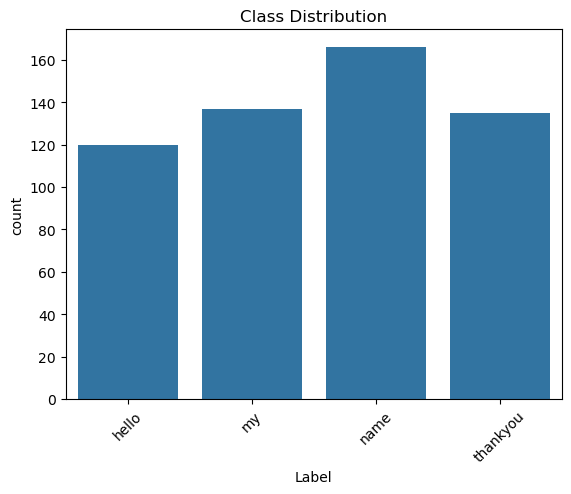

In [15]:
df = pd.DataFrame({'Label': y})
sns.countplot(data=df, x='Label')
plt.xticks(rotation=45)
plt.title("Class Distribution")
plt.show()

# Encode labels

In [16]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_cat = to_categorical(y_encoded)


# Split Dataset

In [17]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y_cat, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y_cat)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val,
    test_size=VAL_SIZE/(1 - TEST_SIZE),
    random_state=RANDOM_STATE,
    stratify=y_train_val
)

print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")


Train: 390, Val: 84, Test: 84


# Build model

In [18]:
model = Sequential([
    Bidirectional(LSTM(64, return_sequences=True), input_shape=(SEQUENCE_LENGTH, FEATURE_DIM)),
    Dropout(0.5),
    Bidirectional(LSTM(64)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(y_cat.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


C:\Users\renal\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_2 (Bidirectional) │ (None, 30, 128)        │        97,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,124 (801.27 KB)

 Trainable params: 205,124 (801.27 KB)

 Non-trainable params: 0 (0.00 B)

# Train Model

In [19]:
checkpoint_path = 'artifacts/best_gesture_model.h5'
early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop, checkpoint]
)


Epoch 1/50
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.4524 - loss: 1.2254

25/25 ━━━━━━━━━━━━━━━━━━━━ 15s 105ms/step - accuracy: 0.4557 - loss: 1.2150 - val_accuracy: 0.7976 - val_loss: 0.7334
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6830 - loss: 0.6956

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.6859 - loss: 0.6928 - val_accuracy: 0.9286 - val_loss: 0.2950
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.9102 - loss: 0.3389 - val_accuracy: 0.7976 - val_loss: 0.5736
Epoch 4/50
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8721 - loss: 0.4686

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.8739 - loss: 0.4603 - val_accuracy: 0.9643 - val_loss: 0.1537
Epoch 5/50
23/25 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9812 - loss: 0.1368

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9795 - loss: 0.1395 - val_accuracy: 0.9643 - val_loss: 0.1278
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9735 - loss: 0.1187 - val_accuracy: 0.9643 - val_loss: 0.1902
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.9709 - loss: 0.1504 - val_accuracy: 0.9643 - val_loss: 0.1453
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.9894 - loss: 0.0512 - val_accuracy: 0.9643 - val_loss: 0.1550
Epoch 9/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.9831 - loss: 0.1099 - val_accuracy: 0.9643 - val_loss: 0.1454
Epoch 10/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9914 - loss: 0.0455

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.9912 - loss: 0.0460 - val_accuracy: 0.9762 - val_loss: 0.1204
Epoch 11/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.9665 - loss: 0.1712 - val_accuracy: 0.9643 - val_loss: 0.1566
Epoch 12/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9781 - loss: 0.1039 - val_accuracy: 0.9405 - val_loss: 0.2422
Epoch 13/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9699 - loss: 0.1140 - val_accuracy: 0.9643 - val_loss: 0.1256
Epoch 14/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.9767 - loss: 0.0870 - val_accuracy: 0.9405 - val_loss: 0.1917
Epoch 15/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.9843 - loss: 0.0805 - val_accuracy: 0.9524 - val_loss: 0.2425
Epoch 16/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.9639 - loss: 0.2201 - val_accuracy: 0.9762 - val_loss: 0.1829
Epoch 17/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.9810 - loss: 0.0838 - val_accuracy: 0.9524 - val_l

# Plot training history

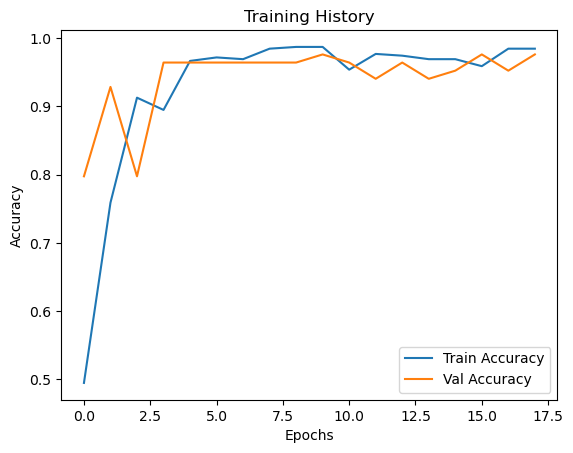

In [20]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training History")
plt.show()


# Evaluate and Analyze Model

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9548 - loss: 0.3278
Test Accuracy: 0.9643
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 707ms/step

Classification Report:
              precision    recall  f1-score   support

       hello       1.00      0.94      0.97        18
          my       1.00      0.95      0.98        21
        name       0.92      0.96      0.94        25
    thankyou       0.95      1.00      0.98        20

    accuracy                           0.96        84
   macro avg       0.97      0.96      0.97        84
weighted avg       0.97      0.96      0.96        84



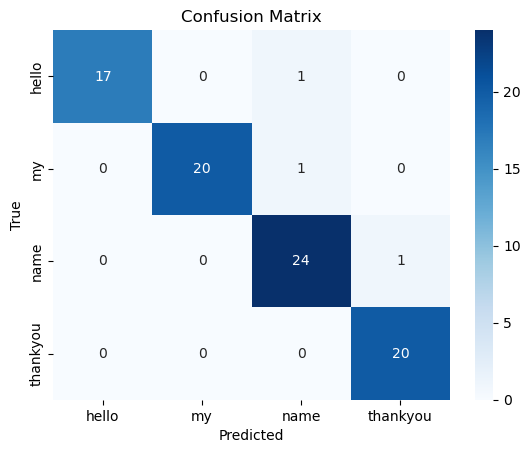

In [21]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

y_pred = model.predict(X_test)
y_pred_labels = le.inverse_transform(np.argmax(y_pred, axis=1))
y_true_labels = le.inverse_transform(np.argmax(y_test, axis=1))

print("\nClassification Report:")
print(classification_report(y_true_labels, y_pred_labels))

cm = confusion_matrix(y_true_labels, y_pred_labels)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


# Save Artifacts

In [22]:
with open('artifacts/label_encoder.pkl', 'wb') as f:
    pickle.dump(le, f)

print("Model and label encoder saved.")


Model and label encoder saved.
